# Applied Machine Learning - HW3

**Student Name: Ze Chen (zc2425), Chunran Yao (cy2511)**

Project Goal: the overall goal is to predict whether a payment by a company to a medical doctor or facility
was made as part of a research project or not.

**In homework3.ipynb, we subsample the data with general:research = 1:1.     
In this ipynb, I subsample the data imbalanced. (general is much more than research).**

In [171]:
#import libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
import category_encoders as ce
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from imblearn.over_sampling import RandomOverSampler

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Import data

In [5]:
General = pd.read_csv("OP_DTL_GNRL_PGYR2017_P01182019.csv")

/anaconda3/envs/aml/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (4,7,9,11,14,16,17,21,22,23,24,28,35,36,37,40,41,42,43,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
Research = pd.read_csv("OP_DTL_RSRCH_PGYR2017_P01182019.csv")

/anaconda3/envs/aml/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (2,5,7,8,9,10,12,15,17,18,19,20,21,22,23,24,25,30,32,35,37,38,42,43,44,45,47,48,49,50,51,52,53,54,55,56,59,60,61,62,67,68,69,70,71,72,73,74,75,76,79,80,81,87,88,89,90,91,92,93,94,95,96,99,100,101,107,108,109,110,111,112,113,114,115,116,119,120,121,129,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,160,161,162,163,173,174,175) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Task 1 Identify Features

Assemble a dataset consisting of features and target (for example in a dataframe or in two arrays X and y). What features are relevant for the prediction task? What features should be excluded because they leak the target information? Show visualizations or statistics to support your selection

### combine two datasets

In [7]:
General['Research'] = 0
Research['Research'] = 1
data = pd.concat([General,Research],join='inner')
data = data.reset_index(drop = True)

### Deal with feature type

In [8]:
data.dtypes[data.dtypes == float]

Teaching_Hospital_CCN                float64
Teaching_Hospital_ID                 float64
Physician_Profile_ID                 float64
Total_Amount_of_Payment_USDollars    float64
dtype: object

In [9]:
data.dtypes[data.dtypes == int]

Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID    int64
Record_ID                                                      int64
Program_Year                                                   int64
Research                                                       int64
dtype: object

Total_Amount_of_Payment_USDollars is the only continuous variable, so we change other variables into object.

In [10]:
data.loc[:,'Teaching_Hospital_CCN'] = data.loc[:,'Teaching_Hospital_CCN'].astype(object)
data.loc[:,'Teaching_Hospital_ID'] = data.loc[:,'Teaching_Hospital_ID'].astype(object)
data.loc[:,'Physician_Profile_ID'] = data.loc[:,'Physician_Profile_ID'].astype(object)
data.loc[:,'Record_ID'] = data.loc[:,'Record_ID'].astype(object)
data.loc[:,'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID'] = data.loc[:,'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID'].astype(object)
data.loc[:,'Program_Year'] = data.loc[:,'Program_Year'].astype(object)
# do not change y to object, otherwise it will raise error when using logistic regression


We also change the order of the columns to put the continuous variables after the categorical variables, which will be convenient for future analysis.

In [11]:
Total_amount = data.loc[:,'Total_Amount_of_Payment_USDollars']
data = data.drop(['Total_Amount_of_Payment_USDollars'],axis = 1)
data.insert(loc = 63, column = 'Total_Amount_of_Payment_USDollars', value = Total_amount)

**The number of levels in each column**

In [12]:
def find_column_level(data):
    """Find the number of levels of a categorical variable
    Parameters:
    data: dataframe
    Returns:
    column_levels_table: number of levels in each column and the column name, dataframe    
    """
    column_names = []
    column_levels = []
    for i in range(data.shape[1]):
        if data.iloc[:,i].dtype == object:
            column_name = data.iloc[:,i].name
            column_level = data.iloc[:,i].unique().shape[0]
            column_names.append(column_name)
            column_levels.append(column_level)
    column_levels_table = pd.DataFrame({'col_names':column_names, 'number of levels':column_levels})
    return column_levels_table

In [13]:
column_levels = find_column_level(data)
column_levels.sort_values(by = 'number of levels', ascending=False)

,col_names,number of levels
33,Record_ID,11266363
5,Physician_Profile_ID,625348
10,Recipient_Primary_Business_Street_Address_Line1,613646
8,Physician_Last_Name,230469
14,Recipient_Zip_Code,225514
11,Recipient_Primary_Business_Street_Address_Line2,91340
6,Physician_First_Name,73418
7,Physician_Middle_Name,47608
12,Recipient_City,20881
39,Name_of_Drug_or_Biological_or_Device_or_Medica...,13563


According from this table, we observe the following facts:</br>
- The value of one column is unique in this dataset : 
    - *Record_ID*
- Some column have too many levels, just using dummy variable may not be a good idea: 
- Some columns have only one value (their values are constant), so they have no contribution to the prediction: 
    - *Delay_in_Publication_Indicator* 
    - *Program_Year*
    - *Payment_Publication_Date*

### Visualization

In [14]:
data_visualization = data.sample(2000)
data_visualization.loc[:,'Total_Amount_of_Payment_USDollars'] = data_visualization.loc[:,'Total_Amount_of_Payment_USDollars'].fillna(data_visualization.loc[:,'Total_Amount_of_Payment_USDollars'].mean())
data_visualization = data_visualization.fillna('missing')

In [15]:
def dependencyPlot(data, rows, cols, height, width):
    """ Draw the plot of dependency between each feature and target
    Parameters:
        data: dataframe
        rows: number of rows
        cols: number of columns
        height: height of figsize
        width: width of figsize
    """
    fig, axes = plt.subplots(rows,cols,figsize = (width, height))
    i = 0
    y = data.iloc[:,-1]
    for m in range(0,rows):
        for n in range(0,cols):
            if i<data.shape[1]-1:
                axes[m,n].set_title("y ~ "+data.iloc[:,i].name)
                X = data.iloc[:,i]
                if X.dtype == object:
                    sns.countplot(x = X.name, hue = y.name, data = data, ax = axes[m,n])
                else:
                    sns.stripplot(x = y.name ,y = X.name, data=data, ax = axes[m,n])
                i = i+1
            else:
                axes[m,n].axis('off')
    plt.setp(axes, yticks=[])
    plt.tight_layout()

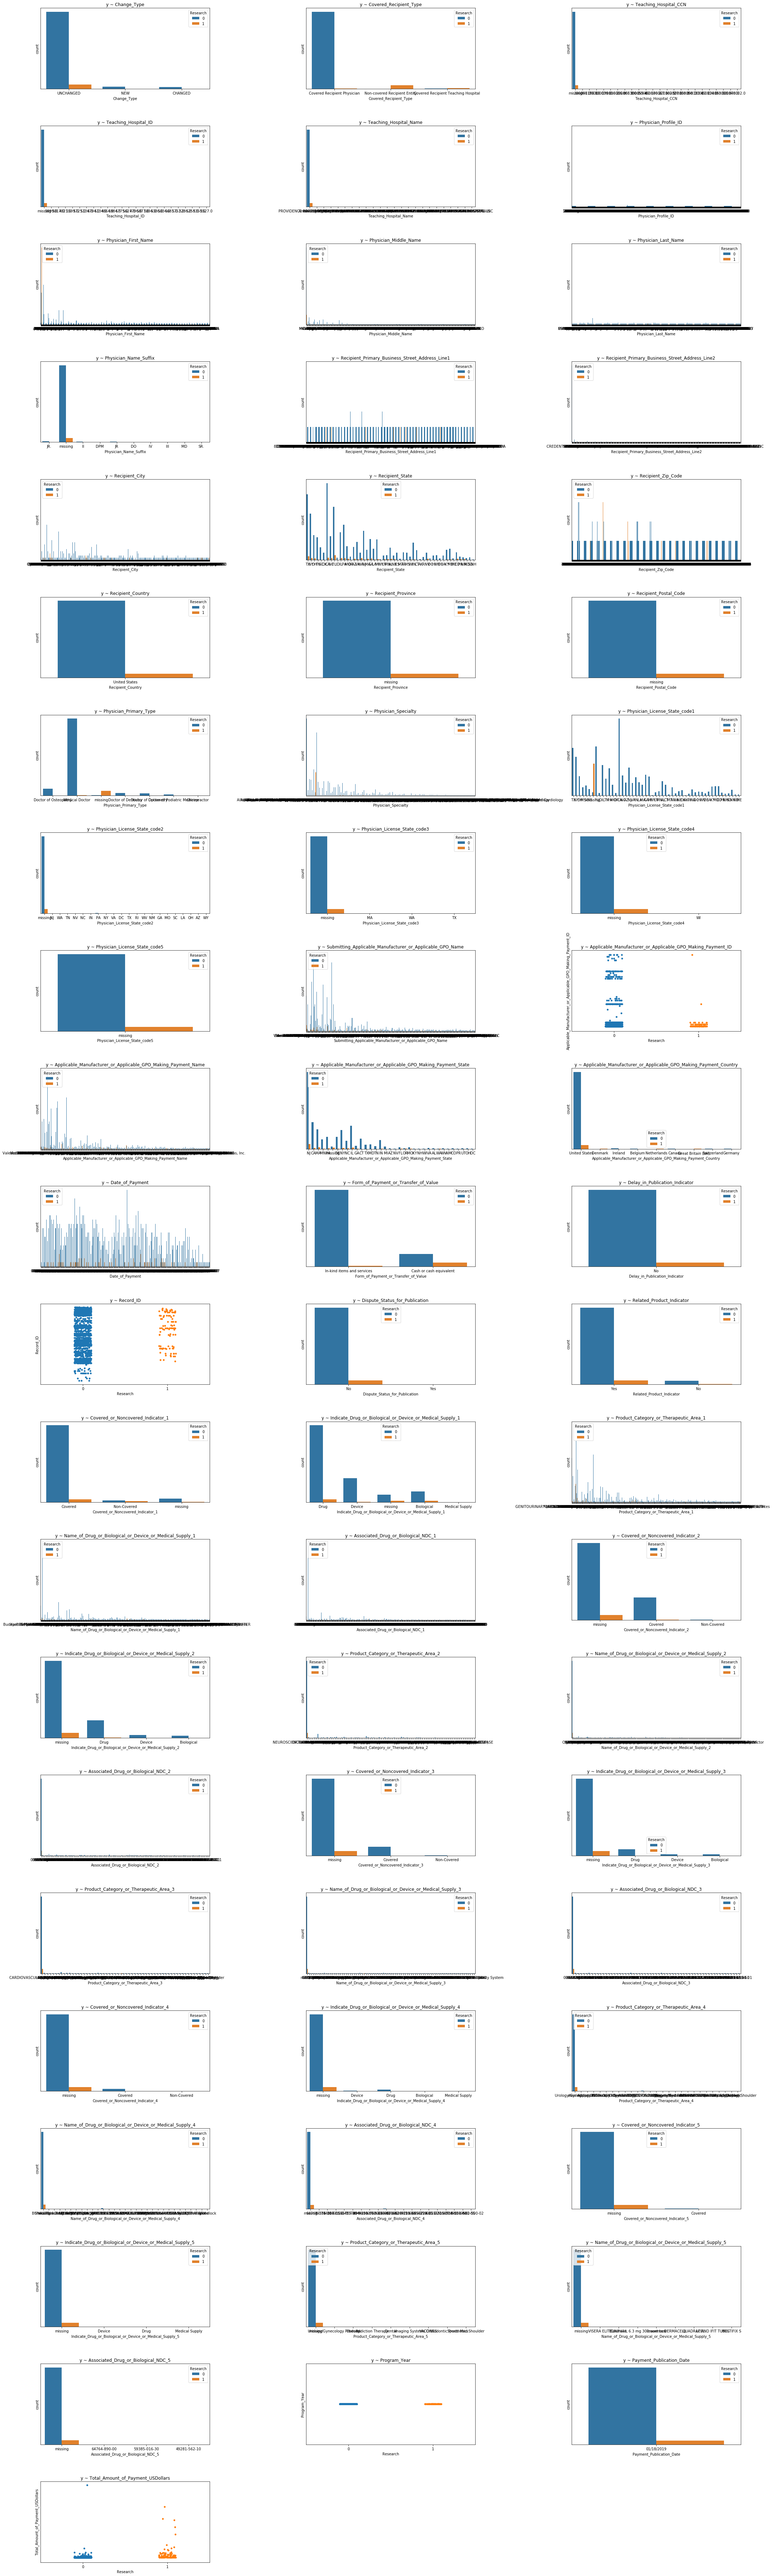

In [16]:
dependencyPlot(data_visualization,22,3,100,30)

Compare with the graph in homework3.ipynb, it is much hard to find a pattern due to the imbalanced data.

### Features that leak information:

**Observed from Data dictionary** </br>   
After reading the data dictionary, we think that apart from the features that is not common in both datasets, these features will also leak target information:
- Covered_Recipient_Type	

**Covered_Recipient_Type**: </br>   
General and Research dataset have different definitions for Covered_Recipient_Type:

General: 'Indicator showing if recipient of the payment or other transfer of value is a physician covered recipient or a teaching hospital';     
Research: 'Indicator showing if recipient of the payment or other transfer of value is a physician covered recipient, teaching hospital covered recipient, non-covered recipient entity or non-covered recipient individual'. Thus, only Research has type 'non-covered recipient entity' or 'non-covered recipient', which will lead information leakage.

The following features are related to Covered_Recipient_Type because whether to fill these fields depends on Covered_Recipient_Type(i.e.: if a Covered_Recipient_Type is Covered Recipient Teaching Hospital, then Teaching_Hospital_CCN, Teaching_Hospital_ID, Teaching_Hospital_Name will be filled, while Physician_Profile_ID, Physician_First_Name, Physician_Middle_Name, Physician_Last_Name, Physician_Name_Suffix, Physician_Primary_Type, Physician_Specialty, Physician_License_State_code1, Physician_License_State_code2, Physician_License_State_code3, Physician_License_State_code4, Physician_License_State_code5 will be left as blank; opposite when Covered_Recipient_Type is Covered Recipient Physician)                                              

so they should also be dropped:
- Teaching_Hospital_CCN
- Teaching_Hospital_ID
- Teaching_Hospital_Name
- Physician_Profile_ID                                               
- Physician_First_Name                                              
- Physician_Middle_Name                                           
- Physician_Last_Name 
- Physician_Name_Suffix
- Physician_Primary_Type
- Physician_Specialty
- Physician_License_State_code1
- Physician_License_State_code2
- Physician_License_State_code3
- Physician_License_State_code4
- Physician_License_State_code5

**Observed During dataset merge**

The following features are either solely belong to Research dataset or solely belong to General dataset, so they also leak information. These features haven been already dropped when we merge Research dataset and General dataset.

'Number_of_Payments_Included_in_Total_Amount',
 'Nature_of_Payment_or_Transfer_of_Value',
 'City_of_Travel',
 'State_of_Travel',
 'Country_of_Travel',
 'Physician_Ownership_Indicator',
 'Third_Party_Payment_Recipient_Indicator',
 'Name_of_Third_Party_Entity_Receiving_Payment_or_Transfer_of_Value',
 'Charity_Indicator',
 'Third_Party_Equals_Covered_Recipient_Indicator',
 'Contextual_Information',
 'Noncovered_Recipient_Entity_Name',
 'Principal_Investigator_1_Profile_ID',
 'Principal_Investigator_1_First_Name',
 'Principal_Investigator_1_Middle_Name',
 'Principal_Investigator_1_Last_Name',
 'Principal_Investigator_1_Name_Suffix',
 'Principal_Investigator_1_Business_Street_Address_Line1',
 'Principal_Investigator_1_Business_Street_Address_Line2',
 'Principal_Investigator_1_City',
 'Principal_Investigator_1_State',
 'Principal_Investigator_1_Zip_Code',
 'Principal_Investigator_1_Country',
 'Principal_Investigator_1_Province',
 'Principal_Investigator_1_Postal_Code',
 'Principal_Investigator_1_Primary_Type',
 'Principal_Investigator_1_Specialty',
 'Principal_Investigator_1_License_State_code1',
 'Principal_Investigator_1_License_State_code2',
 'Principal_Investigator_1_License_State_code3',
 'Principal_Investigator_1_License_State_code4',
 'Principal_Investigator_1_License_State_code5',
 'Principal_Investigator_2_Profile_ID',
 'Principal_Investigator_2_First_Name',
 'Principal_Investigator_2_Middle_Name',
 'Principal_Investigator_2_Last_Name',
 'Principal_Investigator_2_Name_Suffix',
 'Principal_Investigator_2_Business_Street_Address_Line1',
 'Principal_Investigator_2_Business_Street_Address_Line2',
 'Principal_Investigator_2_City',
 'Principal_Investigator_2_State',
 'Principal_Investigator_2_Zip_Code',
 'Principal_Investigator_2_Country',
 'Principal_Investigator_2_Province',
 'Principal_Investigator_2_Postal_Code',
 'Principal_Investigator_2_Primary_Type',
 'Principal_Investigator_2_Specialty',
 'Principal_Investigator_2_License_State_code1',
 'Principal_Investigator_2_License_State_code2',
 'Principal_Investigator_2_License_State_code3',
 'Principal_Investigator_2_License_State_code4',
 'Principal_Investigator_2_License_State_code5',
 'Principal_Investigator_3_Profile_ID',
 'Principal_Investigator_3_First_Name',
 'Principal_Investigator_3_Middle_Name',
 'Principal_Investigator_3_Last_Name',
 'Principal_Investigator_3_Name_Suffix',
 'Principal_Investigator_3_Business_Street_Address_Line1',
 'Principal_Investigator_3_Business_Street_Address_Line2',
 'Principal_Investigator_3_City',
 'Principal_Investigator_3_State',
 'Principal_Investigator_3_Zip_Code',
 'Principal_Investigator_3_Country',
 'Principal_Investigator_3_Province',
 'Principal_Investigator_3_Postal_Code',
 'Principal_Investigator_3_Primary_Type',
 'Principal_Investigator_3_Specialty',
 'Principal_Investigator_3_License_State_code1',
 'Principal_Investigator_3_License_State_code2',
 'Principal_Investigator_3_License_State_code3',
 'Principal_Investigator_3_License_State_code4',
 'Principal_Investigator_3_License_State_code5',
 'Principal_Investigator_4_Profile_ID',
 'Principal_Investigator_4_First_Name',
 'Principal_Investigator_4_Middle_Name',
 'Principal_Investigator_4_Last_Name',
 'Principal_Investigator_4_Name_Suffix',
 'Principal_Investigator_4_Business_Street_Address_Line1',
 'Principal_Investigator_4_Business_Street_Address_Line2',
 'Principal_Investigator_4_City',
 'Principal_Investigator_4_State',
 'Principal_Investigator_4_Zip_Code',
 'Principal_Investigator_4_Country',
 'Principal_Investigator_4_Province',
 'Principal_Investigator_4_Postal_Code',
 'Principal_Investigator_4_Primary_Type',
 'Principal_Investigator_4_Specialty',
 'Principal_Investigator_4_License_State_code1',
 'Principal_Investigator_4_License_State_code2',
 'Principal_Investigator_4_License_State_code3',
 'Principal_Investigator_4_License_State_code4',
 'Principal_Investigator_4_License_State_code5',
 'Principal_Investigator_5_Profile_ID',
 'Principal_Investigator_5_First_Name',
 'Principal_Investigator_5_Middle_Name',
 'Principal_Investigator_5_Last_Name',
 'Principal_Investigator_5_Name_Suffix',
 'Principal_Investigator_5_Business_Street_Address_Line1',
 'Principal_Investigator_5_Business_Street_Address_Line2',
 'Principal_Investigator_5_City',
 'Principal_Investigator_5_State',
 'Principal_Investigator_5_Zip_Code',
 'Principal_Investigator_5_Country',
 'Principal_Investigator_5_Province',
 'Principal_Investigator_5_Postal_Code',
 'Principal_Investigator_5_Primary_Type',
 'Principal_Investigator_5_Specialty',
 'Principal_Investigator_5_License_State_code1',
 'Principal_Investigator_5_License_State_code2',
 'Principal_Investigator_5_License_State_code3',
 'Principal_Investigator_5_License_State_code4',
 'Principal_Investigator_5_License_State_code5',
 'Expenditure_Category1',
 'Expenditure_Category2',
 'Expenditure_Category3',
 'Expenditure_Category4',
 'Expenditure_Category5',
 'Expenditure_Category6',
 'Preclinical_Research_Indicator',
 'Name_of_Study',
 'ClinicalTrials_Gov_Identifier',
 'Research_Information_Link',
 'Context_of_Research'

### Features relevant to prediction task:

In [17]:
data = data.drop(['Covered_Recipient_Type','Teaching_Hospital_CCN',
                  'Teaching_Hospital_ID','Teaching_Hospital_Name',
                  'Physician_Profile_ID', 'Physician_First_Name',
                  'Physician_Middle_Name', 'Physician_Last_Name',
                 'Physician_Name_Suffix', 'Physician_Primary_Type',
                 'Physician_Specialty','Physician_License_State_code1',
                 'Physician_License_State_code2', 'Physician_License_State_code3',
                 'Physician_License_State_code4', 'Physician_License_State_code5'], axis=1)

After excluding variables that leak information, we temporarily consider the following features are relevant to prediction task before further feature engineering are done.

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11266363 entries, 0 to 11266362
Data columns (total 49 columns):
Change_Type                                                         object
Recipient_Primary_Business_Street_Address_Line1                     object
Recipient_Primary_Business_Street_Address_Line2                     object
Recipient_City                                                      object
Recipient_State                                                     object
Recipient_Zip_Code                                                  object
Recipient_Country                                                   object
Recipient_Province                                                  object
Recipient_Postal_Code                                               object
Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name           object
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID         object
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Nam

### Visulization

To support this opinion, draw the dependency plot between them and target.

- Covered_Recipient_Type

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

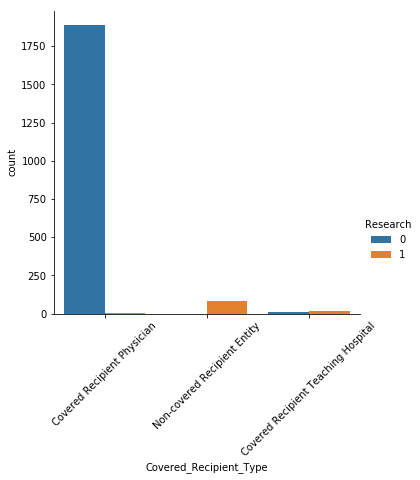

In [19]:
sns.catplot(x = 'Covered_Recipient_Type',hue=data_visualization.iloc[:,-1].name,data=data_visualization,kind = 'count')
plt.xticks(rotation = 45)

**Comments:**

From this visualization, we observe that if a payment is part of research project, its Covered_Recipient_Type is more likely to be Covered Recipient Teaching Hospital and Non-covered Recipient Entity. In contrast, if a payment is not a part of research project, then it's more likely to be covered recipient physician. Also, only research project's paymet can have non-covered recipient entity and non-covered recipient individual. Thus, we need to drop Covered_Recipient_Type and its related variables (as discussed above) to prevent information leakage.

Non-covered Recipient Entity and Non-covered Recipient indivisual will only appear when Research = 1.

- Teaching_Hospital_CCN

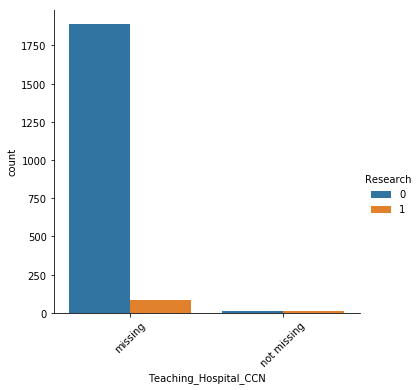

In [20]:
Teaching_Hospital_CCN = data_visualization.loc[:,['Teaching_Hospital_CCN','Research']]
Teaching_Hospital_CCN.loc[Teaching_Hospital_CCN.loc[:,'Teaching_Hospital_CCN']!='missing','Teaching_Hospital_CCN'] = 'not missing'
sns.catplot(x = 'Teaching_Hospital_CCN',hue=Teaching_Hospital_CCN.iloc[:,-1].name,data=Teaching_Hospital_CCN,kind = 'count')
_ = plt.xticks(rotation = 45)


When research = 0, almost all the Teaching_Hospital_CCN is missing.

- Teaching_Hospital_ID

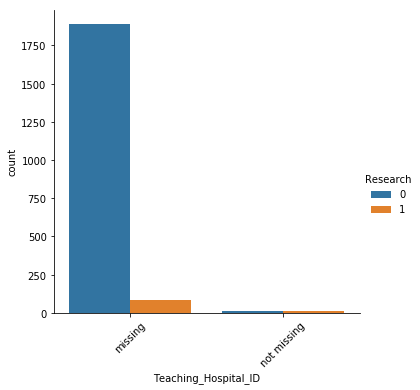

In [21]:
Teaching_Hospital_ID = data_visualization.loc[:,['Teaching_Hospital_ID','Research']]
Teaching_Hospital_ID.loc[Teaching_Hospital_ID.loc[:,'Teaching_Hospital_ID']!='missing','Teaching_Hospital_ID'] = 'not missing'
sns.catplot(x = 'Teaching_Hospital_ID',hue=Teaching_Hospital_ID.iloc[:,-1].name,data=Teaching_Hospital_ID,kind = 'count')
_ = plt.xticks(rotation = 45)

Similar with Teaching_Hospital_CCN.

- Teaching_Hospital_Name

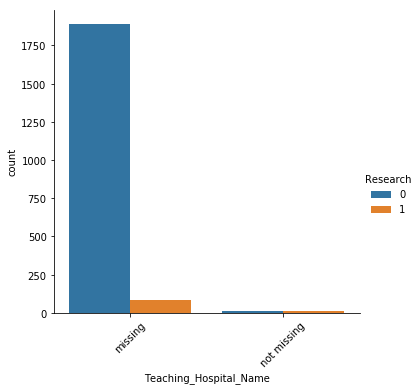

In [22]:
Teaching_Hospital_Name = data_visualization.loc[:,['Teaching_Hospital_Name','Research']]
Teaching_Hospital_Name.loc[Teaching_Hospital_Name.loc[:,'Teaching_Hospital_Name']!='missing','Teaching_Hospital_Name'] = 'not missing'
sns.catplot(x = 'Teaching_Hospital_Name',hue=Teaching_Hospital_Name.iloc[:,-1].name,data=Teaching_Hospital_Name,kind = 'count')
_ = plt.xticks(rotation = 45)

Similar with Teaching_Hospital_CCN and ID.

**Comments:**

From the above three graphs, we observe that only research payment has non-missing value in Teaching_Hospital_CCN, Teaching_Hospital_ID and Teaching_Hospital_Name. Considering information from data dictionary and visualization, these three teaching hospital realted variables are source of information leakage.

- Physician_Primary_Type

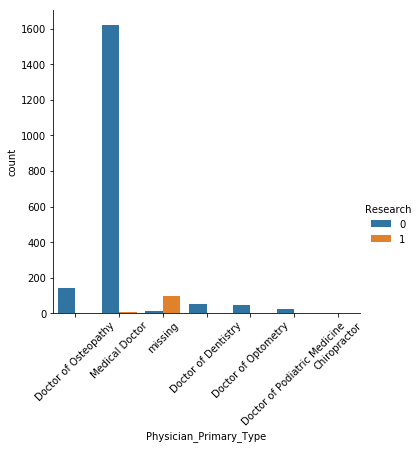

In [23]:
sns.catplot(x = 'Physician_Primary_Type',hue=data_visualization.iloc[:,-1].name,data=data_visualization,kind = 'count')
_ = plt.xticks(rotation = 45)

**Comments:**

Most of the Physician_Primary_Type is missing a payment is part of research project. If payment is not research project, it's Physician_Primary_Type is more likely to be Medical Doctor. This variable also leaks information.     
Similar patterns will also occur for other physician-related variables.

## Task 2 Preprocessing and Baseline Model

Create a simple minimum viable model by doing an initial selection of features, doing appropriate preprocessing and cross-validating a linear model. Feel free to generously exclude features or do simplified preprocessing for this task. As mentioned before, you don’t need to validate the model on the whole dataset

### An initial selection of features

**drop features that leak target information**

In [25]:
#data = data.drop(['Covered_Recipient_Type','Teaching_Hospital_CCN',
                  'Teaching_Hospital_ID','Teaching_Hospital_Name',
                  'Physician_Profile_ID', 'Physician_First_Name',
                  'Physician_Middle_Name', 'Physician_Last_Name',
                 'Physician_Name_Suffix', 'Physician_Primary_Type',
                 'Physician_Specialty','Physician_License_State_code1',
                 'Physician_License_State_code2', 'Physician_License_State_code3',
                 'Physician_License_State_code4', 'Physician_License_State_code5'], axis=1)

Already done in task 1.

**missing data**

In [24]:
def find_column_nan_proportion(data):
    """
    Return proportions of nan for each column
    """
    column_index = np.arange(0,data.shape[1])
    nan_proportion = []
    total_num = data.shape[0]
    for i in column_index:
        proportion = data.iloc[:,i].isna().sum()/total_num
        nan_proportion.append(proportion)
        col_names = data.columns.tolist()
    nan_table = pd.DataFrame({'col_names': col_names, 'nan_proportion': nan_proportion})
    return nan_table

In [25]:
nan_proportion = find_column_nan_proportion(data).sort_values(by = ['nan_proportion'],ascending = False)
nan_proportion

,col_names,nan_proportion
7,Recipient_Province,0.999942
8,Recipient_Postal_Code,0.999928
44,Associated_Drug_or_Biological_NDC_5,0.997653
42,Product_Category_or_Therapeutic_Area_5,0.993616
41,Indicate_Drug_or_Biological_or_Device_or_Medic...,0.993478
43,Name_of_Drug_or_Biological_or_Device_or_Medica...,0.993418
40,Covered_or_Noncovered_Indicator_5,0.993303
39,Associated_Drug_or_Biological_NDC_4,0.983643
37,Product_Category_or_Therapeutic_Area_4,0.977403
36,Indicate_Drug_or_Biological_or_Device_or_Medic...,0.977227


According to the nan_proportion, some columns have too many missing value. It will be hard to deal with these columns, so in the baseline model, we will simply drop them. Specifically, we will drop the features whose nan_proportion is more than 50%.

In [26]:
def drop_nan_columns(data,nan_proportion,threshold):
    """Drop the columns whose nan_proportion is more than threshold
    Paramters:
        data: dataframe
        nan_prportion: dataframe, columns are 'col_names' and 'nan_proportion'
        threshold: float
    Returns:
        data_dropped: new dataframe 
    """
    nan_less = nan_proportion.loc[nan_proportion.loc[:,'nan_proportion']<=threshold]
    nan_less_columns = nan_less.loc[:,'col_names']
    nan_less_columns = pd.DataFrame(nan_less_columns)
    nan_less_columns = nan_less_columns.transpose()
    nan_less_columns.columns = nan_less_columns.iloc[0]
    data_dropped = pd.concat([data,nan_less_columns],join='inner')
    data_dropped = data_dropped.drop('col_names')
    return data_dropped

In [27]:
data_baseline = drop_nan_columns(data,nan_proportion,0.5)

In [28]:
#After concat, all the features are changed to object
data_baseline.loc[:,'Total_Amount_of_Payment_USDollars'] = data_baseline.loc[:,'Total_Amount_of_Payment_USDollars'].astype(float)
data_baseline.loc[:,'Research'] = data_baseline.loc[:,'Research'].astype(int)


**The number of levels in each column**

Also, we drop the features that is unique in this dataset or is contant.

In [29]:
def drop_levels_columns(data,threshold):
    """Drop the columns whose #levels is more than threshold 
        and **the columns whose value is a constant**
    Paramters:
        data: dataframe
        column_levels: dataframe, columns are 'col_names' and 'number of levels'
        threshold: float
    Returns:
        data_dropped: new dataframe 
    """
    column_levels = find_column_level(data)
    level_less = column_levels.loc[column_levels.loc[:,'number of levels']<=threshold]
    level_less = level_less.loc[level_less.loc[:,'number of levels']>1]
    level_less_columns = level_less.loc[:,'col_names']
    continuous_column = data.dtypes[data.dtypes != object]    
    continuous_column = pd.Series(continuous_column.index)
    level_less_columns = continuous_column.append(level_less_columns)
    level_less_columns = pd.DataFrame(level_less_columns)
    level_less_columns = level_less_columns.transpose()
    level_less_columns.columns = level_less_columns.iloc[0]
    data_dropped = pd.concat([data,level_less_columns],join='inner')
    data_dropped = data_dropped.iloc[0:data_dropped.shape[0]-1,:]
    return data_dropped

In [30]:
data_baseline = drop_levels_columns(data_baseline,data_baseline.shape[0]-1)

### Preprocessing & Baseline Model

There are many variables that that are correlated with others. Since it is a baseline model, we simply drop these features:

In [31]:
data_baseline = data_baseline.drop(['Recipient_Primary_Business_Street_Address_Line1',
                 'Recipient_City','Recipient_Zip_Code',
                  'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name',
                  'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
                  'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
                  'Date_of_Payment'], axis=1)

Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID has too many levels, so we drop it for now for baseline model

In [32]:
data_baseline = data_baseline.drop(['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID'], axis=1)

In [33]:
data_baseline.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11266363 entries, 0 to 11266362
Data columns (total 14 columns):
Change_Type                                                  object
Recipient_State                                              object
Recipient_Country                                            object
Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name    object
Form_of_Payment_or_Transfer_of_Value                         object
Dispute_Status_for_Publication                               object
Related_Product_Indicator                                    object
Covered_or_Noncovered_Indicator_1                            object
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1    object
Product_Category_or_Therapeutic_Area_1                       object
Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1     object
Associated_Drug_or_Biological_NDC_1                          object
Total_Amount_of_Payment_USDollars                            object
R

In [34]:
data_baseline.iloc[:,:-2] = data_baseline.iloc[:,:-2].astype(str)
data_baseline.loc[:,'Total_Amount_of_Payment_USDollars'] = data_baseline.loc[:,'Total_Amount_of_Payment_USDollars'].astype(float)
data_baseline.loc[:,'Research'] = data_baseline.loc[:,'Research'].astype(int)
X = data_baseline.iloc[:,:-1]
y = data_baseline.iloc[:,-1]
y = y.astype(int)

In [35]:
categorical = X.dtypes == object

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y)

In [37]:
continuous_transformer = Pipeline(steps=[('imputer',SimpleImputer(strategy = 'median')),
                                         ('scaler',StandardScaler())])
categorical_transformer = Pipeline(steps = [('imputer',SimpleImputer(strategy = 'constant',fill_value = 'missing')),
                                            ('scaler',OneHotEncoder(handle_unknown = 'ignore'))])
preprocess = make_column_transformer((categorical_transformer,categorical),(continuous_transformer,~categorical))


We will use logistic regression as baseline model.

### Baseline Model 1: Just Predict General

In [50]:
y_pred = np.zeros(y_test.shape)
score = accuracy_score(y_pred,y_test)
print('accuracy score of test data: {}'.format(score))
conf_matirx = confusion_matrix(y_pred,y_test)
print('confusion matrix: \n{}'.format(conf_matirx))

accuracy score of test data: 0.9465193917043688
confusion matrix: 
[[2665958  150633]
 [      0       0]]


If I jsut predict general, the accuracy score is 0.94.      
Due to the 0, I cannot calculate f1 score and average_precision (they are NaN).

### Baseline Model 2: Logistic Regression

In [38]:
pipe_logistic = make_pipeline(preprocess, LogisticRegression())
pipe_logistic.fit(X_train, y_train)
score = cross_val_score(pipe_logistic, X_train, y_train).mean()
print('score of train data: {}'.format(score))

/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433:

score of train data: 0.98175051349621


In [39]:
score = pipe_logistic.score(X_test,y_test)
print('score of test data: {}'.format(score))

score of test data: 0.9819018806777413


Compare with homework3.ipynb (score of test data = 0.94), it is surprising that this one is higher. I think it is probably due to the much larger dataset.

In our two baseline models, logistic regression reaches a better score, with test score is around 0.94.

## Task 3 Feature Engineering

In [70]:
data_copy = data.copy()

In [75]:
data = data_copy.copy()

### Sampling the data, otherwise it will take too much time.

In [79]:
data = data.sample(n = 100000)

In [80]:
data.iloc[:,-1].value_counts()

0    94634
1     5366
Name: Research, dtype: int64

### drop features </br>      
All features that leak information have already been dropped.              
Next, we will also drop the features that is constant(Program_Year, Delay_in_Publication_Indicator, Payment_Publication_Date) in the dataset, or whose value is unique in this dataset(Record_ID).

In [81]:
data = drop_levels_columns(data,data.shape[0]-1)

In [82]:
data.loc[:,'Total_Amount_of_Payment_USDollars'] = data.loc[:,'Total_Amount_of_Payment_USDollars'].astype(float)
data.loc[:,'Research'] = data.loc[:,'Research'].astype(int)

### Feature Engineering and Data Cleaning     

- For Zipcode (Recipient_Zip_Code), only keep the first 5 digits.

In [84]:
data.loc[:,'Recipient_Zip_Code'] = data.loc[:,'Recipient_Zip_Code'].str.slice(0,5)

- For 'Recipient_Primary_Business_Street_Address_Line2', change all string to upper class; change all 'STE' to 'SUITE'.

In [90]:
data.loc[:,'Recipient_Primary_Business_Street_Address_Line2'] = \
    data.loc[:,'Recipient_Primary_Business_Street_Address_Line2'].str.upper()
data.loc[:,'Recipient_Primary_Business_Street_Address_Line2'] = \
    data.loc[:,'Recipient_Primary_Business_Street_Address_Line2'].replace({'STE':'SUITE'},regex = True)


- For 'Recipient_City', change all string to upper class

In [91]:
data.loc[:,'Recipient_City'] = data.loc[:,'Recipient_City'].str.upper()

- For 'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name', change all string to upper class

In [92]:
data.loc[:,'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name'] = \
    data.loc[:,'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name'].str.upper()


- For 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name', change all string to upper class

In [93]:
data.loc[:,'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name'] = \
    data.loc[:,'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name'].str.upper()


- For Date (Date_of_Payment), group them into month.

In [94]:
data.loc[:,'Date_of_Payment'] = data.loc[:,'Date_of_Payment'].str.slice(0,2)

### Create Derived varibles:

Derived from Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1 to Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_5:
    - Drug_num: total number of drug associated with this payment
    - Biological_num: total number of biological associated with this payment
    - Device_num: total number of device associated with this payment
    - MedicalSupply_num: total number of medical supply associated with this payment
    
Derived from Covered_or_Noncovered_Indicator_1 to Covered_or_Noncovered_Indicator_5:
    - Covered_num: total number of covered product associated with this payment
    - Non_Covered_num: total number of non-covered product associated with this payment
    

In [95]:
def Supply_Num(dataset,level):
    """
    Return a new dataset having new feature(Drug_num, Biological_num, Device_num, MedicalSupply_num) 
    derived from Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1 to 
    Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_5
    """
    dataset.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1[
        dataset.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1 == level] = 1
    dataset.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2[
        dataset.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2 == level] = 1
    dataset.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_3[
        dataset.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_3 == level] = 1
    dataset.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_4[
        dataset.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_4 == level] = 1
    dataset.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_5[
        dataset.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_5 == level] = 1

    dataset.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1[
        dataset.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1 != 1] = 0
    dataset.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2[
        dataset.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2 != 1] = 0
    dataset.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_3[
        dataset.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_3 != 1] = 0
    dataset.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_4[
        dataset.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_4 != 1] = 0
    dataset.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_5[
        dataset.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_5 != 1] = 0

    return dataset


In [96]:
temp_data = data.copy()
temp_data = Supply_Num(temp_data, 'Drug')
temp_data['Drug_num'] = temp_data.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1 + \
                        temp_data.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2 + \
                        temp_data.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_3 + \
                        temp_data.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_4 + \
                        temp_data.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_5

/anaconda3/envs/aml/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/envs/aml/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/envs/aml/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/anaconda3/envs/aml/lib/python3.7/site-packages/ipykerne

In [98]:
temp_data2 = data.copy()
temp_data2 = Supply_Num(temp_data2, 'Biological')
temp_data2['Biological_num'] = temp_data2.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1 + \
                        temp_data2.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2 + \
                        temp_data2.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_3 + \
                        temp_data2.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_4 + \
                        temp_data2.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_5

/anaconda3/envs/aml/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/envs/aml/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/envs/aml/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/anaconda3/envs/aml/lib/python3.7/site-packages/ipykerne

In [99]:
temp_data3 = data.copy()
temp_data3 = Supply_Num(temp_data3, 'Device')
temp_data3['Device_num'] = temp_data3.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1 + \
                        temp_data3.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2 + \
                        temp_data3.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_3 + \
                        temp_data3.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_4 + \
                        temp_data3.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_5

/anaconda3/envs/aml/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/envs/aml/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/envs/aml/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/anaconda3/envs/aml/lib/python3.7/site-packages/ipykerne

In [100]:
temp_data4 = data.copy()
temp_data4 = Supply_Num(temp_data4, 'Medical Supply')
temp_data4['MedicalSupply_num'] = temp_data4.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1 + \
                        temp_data4.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2 + \
                        temp_data4.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_3 + \
                        temp_data4.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_4 + \
                        temp_data4.Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_5

/anaconda3/envs/aml/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/envs/aml/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/envs/aml/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/anaconda3/envs/aml/lib/python3.7/site-packages/ipykerne

In [101]:
def Cover_Num(dataset,level):
    """
    Return a new dataset having new feature(Covered_num or Non_Covered_num) derived from 
    Covered_or_Noncovered_Indicator_1 to Covered_or_Noncovered_Indicator_5
    """
    dataset.Covered_or_Noncovered_Indicator_1[dataset.Covered_or_Noncovered_Indicator_1 == level] = 1
    dataset.Covered_or_Noncovered_Indicator_2[dataset.Covered_or_Noncovered_Indicator_2 == level] = 1
    dataset.Covered_or_Noncovered_Indicator_3[dataset.Covered_or_Noncovered_Indicator_3 == level] = 1
    dataset.Covered_or_Noncovered_Indicator_4[dataset.Covered_or_Noncovered_Indicator_4 == level] = 1
    dataset.Covered_or_Noncovered_Indicator_5[dataset.Covered_or_Noncovered_Indicator_5 == level] = 1
    
    dataset.Covered_or_Noncovered_Indicator_1[dataset.Covered_or_Noncovered_Indicator_1 != 1] = 0
    dataset.Covered_or_Noncovered_Indicator_2[dataset.Covered_or_Noncovered_Indicator_2 != 1] = 0
    dataset.Covered_or_Noncovered_Indicator_3[dataset.Covered_or_Noncovered_Indicator_3 != 1] = 0
    dataset.Covered_or_Noncovered_Indicator_4[dataset.Covered_or_Noncovered_Indicator_4 != 1] = 0
    dataset.Covered_or_Noncovered_Indicator_5[dataset.Covered_or_Noncovered_Indicator_5 != 1] = 0
    
    return dataset

In [102]:
temp_data5 = data.copy()
temp_data5 = Cover_Num(temp_data5, 'Covered')
temp_data5['Covered_num'] = temp_data5.Covered_or_Noncovered_Indicator_1 + \
                        temp_data5.Covered_or_Noncovered_Indicator_2 + \
                        temp_data5.Covered_or_Noncovered_Indicator_3 + \
                        temp_data5.Covered_or_Noncovered_Indicator_4 + \
                        temp_data5.Covered_or_Noncovered_Indicator_5

/anaconda3/envs/aml/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/envs/aml/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/envs/aml/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/envs/aml/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to b

In [103]:
temp_data6 = data.copy()
temp_data6 = Cover_Num(temp_data6, 'Non-Covered')
temp_data6['Non_Covered_num'] = temp_data6.Covered_or_Noncovered_Indicator_1 + \
                        temp_data6.Covered_or_Noncovered_Indicator_2 + \
                        temp_data6.Covered_or_Noncovered_Indicator_3 + \
                        temp_data6.Covered_or_Noncovered_Indicator_4 + \
                        temp_data6.Covered_or_Noncovered_Indicator_5

/anaconda3/envs/aml/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/envs/aml/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/envs/aml/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/envs/aml/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to b

In [104]:
drugnum = temp_data['Drug_num']
bionum =temp_data2['Biological_num']
devicenum = temp_data3['Device_num']
supplynum = temp_data4['MedicalSupply_num']
covernum = temp_data5['Covered_num']
noncovernum = temp_data6['Non_Covered_num']
research = data['Research']
data_noresearch = data.drop(['Research'], axis=1)

In [105]:
result = pd.concat([data_noresearch, bionum, drugnum, devicenum, supplynum, covernum, noncovernum, research], 
                   axis=1, sort=False)

In [106]:
previous_data = data.copy()
data = result

In [107]:
data.loc[:,'Biological_num'] = data.loc[:,'Biological_num'].astype(int)
data.loc[:,'Drug_num'] = data.loc[:,'Drug_num'].astype(int)
data.loc[:,'Device_num'] = data.loc[:,'Device_num'].astype(int)
data.loc[:,'MedicalSupply_num'] = data.loc[:,'MedicalSupply_num'].astype(int)
data.loc[:,'Covered_num'] = data.loc[:,'Covered_num'].astype(int)
data.loc[:,'Non_Covered_num'] = data.loc[:,'Non_Covered_num'].astype(int)

### Combine levels: 

change levels that occur less than 10 times in a variable into 'other'

In [129]:
def combine_levels(data,threshold):
    """combine the levels with value counts fewer than threshold (<threshold) as other
    Parameters:
        data: dataframe
        threshold: int
    Return:
        data_new: dataframe  
    """
    col_to_combine = data.columns
    for col in col_to_combine:
        if data.loc[:,col].dtype == object:
            temp = data.loc[:,col].value_counts()
            levels = temp.loc[temp<threshold].index
            for level in levels:
                data.loc[:,col] = data.loc[:,col].replace(level,'other')
    return data

In [109]:
data = combine_levels(data,10)

### Encoder

**One hot encoder + Target encoder**

We create two encoding strategies by creating two column transformer:

- preprocess: use OneHotEncoder for categorical variables
- preprocess_target: use OneHotEncoder for categorical variables with low levels, use TargetHotEncoder for high level categorical variables

In [111]:
data.iloc[:,:-8] = data.iloc[:,:-8].astype(str)
data.loc[:,'Total_Amount_of_Payment_USDollars'] = data.loc[:,'Total_Amount_of_Payment_USDollars'].astype(float)
data.loc[:,'Research'] = data.loc[:,'Research'].astype(int)
data.loc[:,'Biological_num'] = data.loc[:,'Biological_num'].astype(int)
data.loc[:,'Drug_num'] = data.loc[:,'Drug_num'].astype(int)
data.loc[:,'Device_num'] = data.loc[:,'Device_num'].astype(int)
data.loc[:,'MedicalSupply_num'] = data.loc[:,'MedicalSupply_num'].astype(int)
data.loc[:,'Covered_num'] = data.loc[:,'Covered_num'].astype(int)
data.loc[:,'Non_Covered_num'] = data.loc[:,'Non_Covered_num'].astype(int)

In [162]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify = y)

In [151]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 4377495 to 1042713
Data columns (total 51 columns):
Change_Type                                                         100000 non-null object
Recipient_Primary_Business_Street_Address_Line1                     100000 non-null object
Recipient_Primary_Business_Street_Address_Line2                     100000 non-null object
Recipient_City                                                      100000 non-null object
Recipient_State                                                     100000 non-null object
Recipient_Zip_Code                                                  100000 non-null object
Recipient_Country                                                   100000 non-null object
Recipient_Province                                                  100000 non-null object
Recipient_Postal_Code                                               100000 non-null object
Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name      

In [163]:
X_copy = X.copy()
y_copy = y.copy()

In [124]:
#category_encoders 1.3.0 cannot deal with uncontinuous index
#https://github.com/scikit-learn-contrib/categorical-encoding/issues/151
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [154]:
continuous = X.dtypes != object

In [155]:
column_levels = find_column_level(data)
high_level_col_name = column_levels.loc[column_levels.loc[:,'number of levels']>5,'col_names']

In [156]:
high_level_col_name = list(high_level_col_name)
high_level_col = []
for i in range(0,X.shape[1]):
    if X.iloc[:,i].name not in high_level_col_name:
        high_level_col.append(False)
    else:
        high_level_col.append(True)
high_level_col = pd.Series(high_level_col, index=X.columns)

categorical = []
categorical_name = []
for i in range(0,X.shape[1]):
    if X.iloc[:,i].name not in high_level_col_name and X.iloc[:,i].dtype == object:
        categorical.append(True)
        categorical_name.append(X.iloc[:,i].name)
    else:
        categorical.append(False)
categorical = pd.Series(categorical, index=X.columns)


Create a column transformer called **preprocess_target** using target encoding for categorical variables with many levels and OneHotEncoder other categorical variables

In [157]:
continuous_transformer = Pipeline(steps=[('imputer',SimpleImputer(strategy = 'median')),('scaler',RobustScaler())])
#continuous_transformer = Pipeline(steps=[('imputer',SimpleImputer(strategy = 'median'))])
#continuous_transformer = Pipeline(steps=[('imputer',SimpleImputer(strategy = 'median')),('scaler',StandardScaler())])
categorical_transformer = Pipeline(steps = [('imputer',SimpleImputer(strategy = 'constant',fill_value = 'missing')),
                                            ('scaler',OneHotEncoder(handle_unknown = 'ignore',sparse=False))])
high_level_transformer = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'constant',fill_value = 'missing')),
                                           ('scaler',ce.TargetEncoder())])
preprocess_target = make_column_transformer((categorical_transformer,categorical),
                                            (high_level_transformer,high_level_col),
                                            (continuous_transformer,continuous))


Create a column transformer called **preprocess** using OneHotEncoder for all categorical variables

In [158]:
continuous_transformer = Pipeline(steps=[('imputer',SimpleImputer(strategy = 'median')),('scaler',RobustScaler())])
categorical_transformer = Pipeline(steps = [('imputer',SimpleImputer(strategy = 'constant',fill_value = 'missing')),
                                            ('scaler',OneHotEncoder(handle_unknown = 'ignore'))])
preprocess = make_column_transformer((categorical_transformer,~continuous),(continuous_transformer,continuous))

## Task 4 Any Model

Use any classification model we discussed (trees, forests, gradient boosting, SVM) to improve your result. You can (and probably should) change your preprocessing and feature engineering to be suitable for the model. You are not required to try all of these models. Tune parameters as appropriate.

### Logisitc Regression

**Baseline**

In [167]:
pipeline_lr = make_pipeline(preprocess,LogisticRegressionCV())
scores  = cross_validate(pipeline_lr,X_train,y_train, cv = 5, scoring = ('roc_auc','average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: Convergence

/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: Convergence

/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

(0.9887236823393767, 0.8865801594080276)

**Naive Random Undersampling**

In [172]:
pipeline_lr_rus = make_im_pipeline(preprocess,RandomUnderSampler(),LogisticRegressionCV())
scores  = cross_validate(pipeline_lr_rus,X_train,y_train, cv = 5, scoring = ('roc_auc','average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9862995762220536, 0.8062121947465769)

**Edited Nearest Neighbours**

In [177]:
from imblearn.under_sampling import EditedNearestNeighbours

In [178]:
pipeline_lr_enn = make_im_pipeline(preprocess,EditedNearestNeighbours(n_neighbors = 5),LogisticRegressionCV())
scores  = cross_validate(pipeline_lr_enn,X_train,y_train, cv = 5, scoring = ('roc_auc','average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9882976203238389, 0.8280557279836925)

it takes toooooooo long time. (Much longer than RandomOverSampler)

**Condensed Nearest Neigbours**

In [179]:
from imblearn.under_sampling import CondensedNearestNeighbour

In [180]:
#uncomment these lines if you want to use this method
#pipeline_lr_cnn = make_im_pipeline(preprocess,CondensedNearestNeighbour(),LogisticRegressionCV())
#scores  = cross_validate(pipeline_lr_cnn,X_train,y_train, cv = 5, scoring = ('roc_auc','average_precision'))
#scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

Not running this method since it may take too much time.      
It is expensive even than training the whole data. Usually it is better than random under-sampling.--Andreas Mueller, _Applied Machine Learning_

**Naive Random Oversampling**

In [140]:
from imblearn.pipeline import make_pipeline as make_im_pipeline
from imblearn.pipeline import Pipeline as im_pipeline

In [136]:
from imblearn.over_sampling import RandomOverSampler

In [170]:
pipeline_lr_ros = make_im_pipeline(preprocess,RandomOverSampler(),LogisticRegressionCV())
scores  = cross_validate(pipeline_lr_ros,X_train,y_train, cv = 5, scoring = ('roc_auc','average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: Convergence

/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

(0.9898206830766674, 0.8650746672757992)

**SMOTE**

In [181]:
from imblearn.over_sampling import SMOTE

In [182]:
pipeline_lr_smote = make_im_pipeline(preprocess,SMOTE(),LogisticRegressionCV())
scores  = cross_validate(pipeline_lr_smote,X_train,y_train, cv = 5, scoring = ('roc_auc','average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.989591821107511, 0.873278218444011)

**class weight**

In [173]:
pipeline_lr_weight = make_im_pipeline(preprocess,LogisticRegressionCV(class_weight = 'balanced'))
scores  = cross_validate(pipeline_lr_weight,X_train,y_train, cv = 5, scoring = ('roc_auc','average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9899692788336371, 0.8665061156685747)

### Linear SVM

**Baseline**

In [165]:
pipeline_linearsvc = make_pipeline(preprocess,LinearSVC())

In [166]:
param_grid = {'linearsvc__C':np.logspace(-3,3,13)}
grid_lnearsvc = GridSearchCV(pipeline_linearsvc,param_grid, cv = 5)
grid_lnearsvc.fit(X_train,y_train)
print (grid_lnearsvc.best_params_)
print (grid_lnearsvc.best_score_)

/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the

/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the

{'linearsvc__C': 0.03162277660168379}
0.98084


/anaconda3/envs/aml/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [82]:
pipeline_linearsvc = make_pipeline(preprocess,LinearSVC(C = grid_lnearsvc.best_params_['linearsvc__C']))
pipeline_linearsvc.fit(X_train,y_train)
score = pipeline_linearsvc.score(X_test,y_test)
score

0.9594

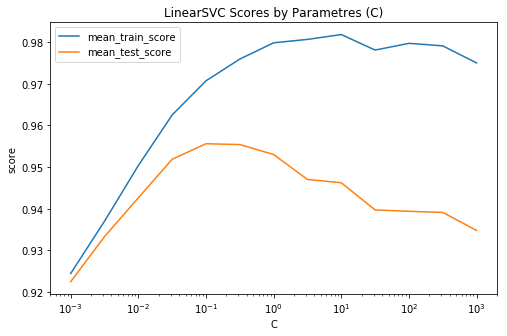

In [83]:
#get lists of mean_train_score and mean_test_score
param_list = np.logspace(-3,3,13)
linearsvc_mean_train_score = grid_lnearsvc.cv_results_['mean_train_score']
linearsvc_mean_test_score = grid_lnearsvc.cv_results_['mean_test_score']

#Plot graph
fig= plt.figure(figsize=(8,5))
plt.plot(param_list, linearsvc_mean_train_score, label = 'mean_train_score')
plt.plot(param_list, linearsvc_mean_test_score, label = 'mean_test_score')
plt.legend()
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('score')
plt.title('LinearSVC Scores by Parametres (C)')
plt.show()

### Random Forests

**Baseline**

In [189]:
pipeline_rf = make_pipeline(preprocess,RandomForestClassifier(warm_start = True))
estimator_range = range(1,100,5)
#train_scores = []
#test_scores = []
roc_auc_train_score = []
ave_precision_train_score = []
roc_auc_test_score = []
ave_precision_test_score = []
n_estimators_list = []
for n_estimators in estimator_range:
    pipeline_rf.named_steps['randomforestclassifier'].n_estimators = n_estimators
    pipeline_rf.fit(X_train,y_train)
    scores = cross_validate(pipeline_rf,X_train,y_train, cv = 5, scoring = ('roc_auc','average_precision'))
    roc_auc_train_score.append(scores['train_roc_auc'].mean())
    roc_auc_test_score.append(scores['test_roc_auc'].mean())
    ave_precision_train_score.append(scores['train_average_precision'].mean())
    ave_precision_test_score.append(scores['test_average_precision'].mean())
    #train_scores.append(pipeline_rf.score(X_train, y_train))
    #test_scores.append(pipeline_rf.score(X_test, y_test))
    n_estimators_list.append(n_estimators)

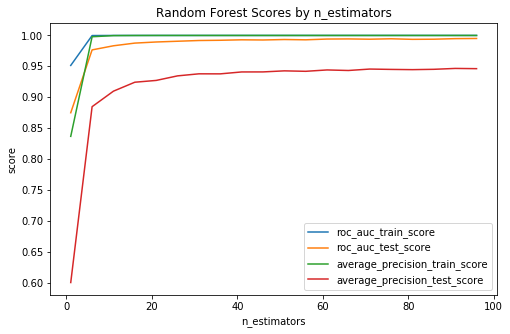

In [190]:
#Plot graph
fig= plt.figure(figsize=(8,5))
plt.plot(n_estimators_list, roc_auc_train_score, label = 'roc_auc_train_score')
plt.plot(n_estimators_list, roc_auc_test_score, label = 'roc_auc_test_score')
plt.plot(n_estimators_list, ave_precision_train_score, label = 'average_precision_train_score')
plt.plot(n_estimators_list, ave_precision_test_score, label = 'average_precision_test_score')
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.title('Random Forest Scores by n_estimators')
plt.show()

It is better enough when n_estimators = 26.

In [195]:
roc_auc_test_score[5], ave_precision_test_score[5]

(0.9906234239595344, 0.9345759304984707)

**Easy Ensemble**

BalancedBaggingClassifier allows to resample each subset of data before to train each estimator of the ensemble.

In [174]:
from imblearn.ensemble import BalancedBaggingClassifier

In [186]:
from sklearn.tree import DecisionTreeClassifier

In [187]:
tree = DecisionTreeClassifier(max_features='auto')  #If “auto”, then max_features=sqrt(n_features).

In [188]:
pipeline_rf_bagging = make_im_pipeline(preprocess,BalancedBaggingClassifier(base_estimator=tree,n_estimators=100))
scores  = cross_validate(pipeline_rf_bagging,X_train,y_train, cv = 5, scoring = ('roc_auc','average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()


(0.9941787743475416, 0.9210004717170255)

**Easy Ensemble**

BalancedRandomForestClassifier is another ensemble method in which each tree of the forest will be provided a balanced bootstrap sample.

In [198]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [199]:
pipeline_rf_baggingrf = make_im_pipeline(preprocess, BalancedRandomForestClassifier(n_estimators = 100))
scores  = cross_validate(pipeline_rf_baggingrf,X_train,y_train, cv = 5, scoring = ('roc_auc','average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()


(0.9873426606779134, 0.8563876037650644)

### Gradient Boosting

**Only Use OneHotEncoder**

In [208]:
#pipe_gbdt = make_pipeline(preprocess,LGBMClassifier(n_estimators=200))
pipe_gbdt = make_pipeline(preprocess,GradientBoostingClassifier())
param_grid = {'gradientboostingclassifier__learning_rate':[1, 0.5, 0.25, 0.1, 0.05, 0.01]}
grid_gbdt = GridSearchCV(pipe_gbdt,param_grid)
#0.05, 0.1, 0.15, 0.2

In [209]:
grid_gbdt.fit(X_train,y_train)
train_score = grid_gbdt.score(X_train,y_train)

In [210]:
print (grid_gbdt.best_params_)
print (grid_gbdt.best_score_)

{'gradientboostingclassifier__learning_rate': 0.5}
0.963


In [211]:
test_score = grid_gbdt.score(X_test,y_test)
test_score

0.9664

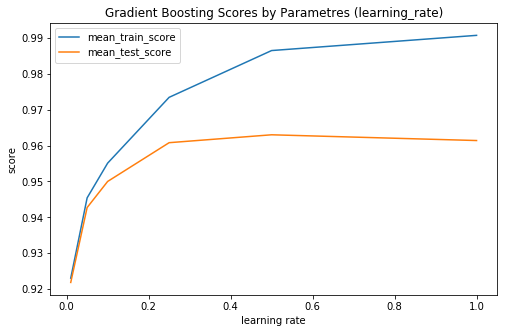

In [212]:
#get lists of mean_train_score and mean_test_score
param_list = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
gbdt_mean_train_score = grid_gbdt.cv_results_['mean_train_score']
gbdt_mean_test_score = grid_gbdt.cv_results_['mean_test_score']

#Plot graph
fig= plt.figure(figsize=(8,5))
plt.plot(param_list, gbdt_mean_train_score, label = 'mean_train_score')
plt.plot(param_list, gbdt_mean_test_score, label = 'mean_test_score')
plt.legend()
plt.xlabel('learning rate')
plt.ylabel('score')
plt.title('Gradient Boosting Scores by Parametres (learning_rate)')
plt.show()

Tune max_depth and min_samples_split :

min_samples_split: this should be ~0.5-1% of total values. We’ll take a small value from the range.

In [226]:
pipe_gbdt = make_pipeline(preprocess,GradientBoostingClassifier())
param_grid = {'gradientboostingclassifier__max_depth':[2,3,4,5,6,7],
             'gradientboostingclassifier__min_samples_split':range(75,165,20)}
grid_gbdt = GridSearchCV(pipe_gbdt,param_grid)

In [177]:
grid_gbdt.fit(X_train,y_train)
train_score = grid_gbdt.score(X_train,y_train)

In [178]:
train_score

0.9773333333333334

In [179]:
print (grid_gbdt.best_params_)
print (grid_gbdt.best_score_)

{'gradientboostingclassifier__max_depth': 7, 'gradientboostingclassifier__min_samples_split': 95}
0.9634


In [181]:
test_score = grid_gbdt.score(X_test,y_test)
test_score

0.9658

**Use TargetEncoder and OneHotEncoder**

In [202]:
pipe_gbdt_target = make_pipeline(preprocess_target,GradientBoostingClassifier())
param_grid = {'gradientboostingclassifier__learning_rate':[1, 0.5, 0.25, 0.1, 0.05, 0.01]}
grid_gbdt_target = GridSearchCV(pipe_gbdt_target,param_grid)

In [203]:
grid_gbdt_target.fit(X_train,y_train)
train_score = cross_val_score(grid_gbdt_target, X_train,y_train).mean()
train_score

0.9574666666666666

In [204]:
test_score = grid_gbdt_target.score(X_test,y_test)
test_score

0.9686

In [206]:
print (grid_gbdt_target.best_params_)
print (grid_gbdt_target.best_score_)

{'gradientboostingclassifier__learning_rate': 0.5}
0.9607333333333333


Plot Graph of mean score and test score by learning rate

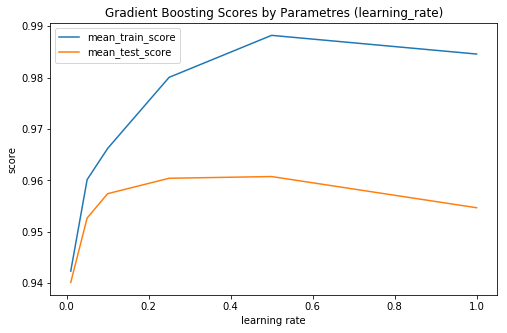

In [207]:
#get lists of mean_train_score and mean_test_score
param_list = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
gbdt_target_mean_train_score = grid_gbdt_target.cv_results_['mean_train_score']
gbdt_target_mean_test_score = grid_gbdt_target.cv_results_['mean_test_score']

#Plot graph
fig= plt.figure(figsize=(8,5))
plt.plot(param_list, gbdt_target_mean_train_score, label = 'mean_train_score')
plt.plot(param_list, gbdt_target_mean_test_score, label = 'mean_test_score')
plt.legend()
plt.xlabel('learning rate')
plt.ylabel('score')
plt.title('Gradient Boosting Scores by Parametres (learning_rate)')
plt.show()

**Conclusion:**

By comparision, we find that Gradient Boosting has similiar performance for Target Encoding and One Hot Encoding, so we will choose between these two encoding strategies depends on computational speed or interpretability.

In this task, we will choose **Gradient Boosting** as our best model.

Result of tuning hyperparametres for Gradient Boosting: **learning_rate = 0.5, max_depth =7, min_samples_split=95**

## Task 5 Feature Selections

Identify features that are important for your best model. Which features are most influential, and which features could be removed without decrease in performance? Does removing irrelevant features make your model better?

### PCA

we first use PCA to get some sense about the number of meaningful features we may reduce to.

In [228]:
from sklearn.decomposition import PCA
pca_gbdt = make_pipeline(preprocess_target, PCA(n_components=15), 
                       GradientBoostingClassifier(learning_rate = 0.5, max_depth =7, min_samples_split=95)) 
pca_gbdt.fit(X_train, y_train)
print(pca_gbdt.score(X_train, y_train))
print(pca_gbdt.score(X_test, y_test))

0.9997333333333334
0.9562


In [240]:
pca_gbdt = make_pipeline(preprocess,PCA(), 
                       GradientBoostingClassifier(learning_rate = 0.5, max_depth =7, min_samples_split=95))
param_grid = {'pca__n_components':np.arange(1,21,1)}
grid_pca_gbdt = GridSearchCV(pca_gbdt,param_grid)

In [241]:
grid_pca_gbdt.fit(X_train,y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('pipeline-1', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value='missing', missing_values=nan,
       strateg...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'pca__n_components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

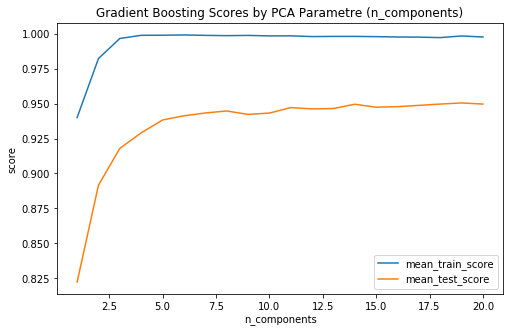

In [248]:
#get lists of mean_train_score and mean_test_score
param_list = np.arange(1,21,1)
grid_pca_mean_train_score = grid_pca_gbdt.cv_results_['mean_train_score']
grid_pca_target_mean_test_score = grid_pca_gbdt.cv_results_['mean_test_score']

#Plot graph
fig= plt.figure(figsize=(8,5))
plt.plot(param_list, grid_pca_mean_train_score, label = 'mean_train_score')
plt.plot(param_list, grid_pca_target_mean_test_score, label = 'mean_test_score')
plt.legend()
plt.xlabel('n_components')
plt.ylabel('score')
plt.title('Gradient Boosting Scores by PCA Parametre (n_components)')
plt.show()

### Feature Importance for My Best Model: Gradient Boosting

In [227]:
pipe_gbdt.fit(X_train,y_train)
gbdt_importance = pipe_gbdt.named_steps['gradientboostingclassifier'].feature_importances_

In [228]:
cate_index_name = pipe_gbdt.named_steps['columntransformer'].named_transformers_['pipeline-1'].named_steps['scaler'].get_feature_names()
ohe_index_name = list(cate_index_name)
ohe_index_name = ohe_index_name
ohe_index_name.append('Total_Amount_of_Payment_USDollars')
ohe_index_name.append('Biological_num')
ohe_index_name.append('Drug_num')
ohe_index_name.append('Device_num')
ohe_index_name.append('MedicalSupply_num')
ohe_index_name.append('Covered_num')
ohe_index_name.append('Non_Covered_num')
ohe_index_name = pd.Index(ohe_index_name)

In [229]:
gbdt_feature_importance = pd.Series(gbdt_importance,index = ohe_index_name)
gbdt_feature_importance.nlargest(30)

Total_Amount_of_Payment_USDollars                 0.608821
x16_Cash or cash equivalent                       0.074464
x16_In-kind items and services                    0.030257
x13_nan                                           0.028294
x14_United States                                 0.026097
Device_num                                        0.025942
x19_Covered                                       0.021357
x10_INCYTE CORPORATION                            0.015295
x11_100000000067                                  0.014694
x2_other                                          0.012523
x11_100000000263                                  0.011669
x19_Non-Covered                                   0.009624
x10_other                                         0.008952
x12_BIOGEN, INC.                                  0.008764
x21_ONCOLOGY                                      0.008158
x10_BOEHRINGER INGELHEIM CORPORATE CENTER GMBH    0.007860
x11_100000000193                                  0.0055

**Which features are most influential**

From GradientBoostingClassifier's feature importance, we can see that 
- Total_Amount_of_Payment_USDollars
- Form_of_Payment_or_Transfer_of_Value
- Device_num 
- Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country  
- Covered_or_Noncovered_Indicator_1                
are important features

**Which features could be removed without decrease in performance? Does removing irrelevant features make your model better?**

Find all features whose feature importance is not 0 and then remove features having 0 feature importance, build a new Gradient Boosting Classifier on the reduced features and then compare with previous model.

In [258]:
gb_importance = pd.DataFrame(gbdt_feature_importance).reset_index()
gb_importance = gb_importance.rename(columns={'index': 'feature', 0: 'importance'})

In [272]:
previous_X_train = X_train.copy()

In [292]:
feature_lst = ['Change_Type', 'Recipient_Primary_Business_Street_Address_Line1',
       'Recipient_Primary_Business_Street_Address_Line2', 'Recipient_City',
       'Recipient_State', 'Recipient_Zip_Code',
        'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
       'Date_of_Payment', 'Form_of_Payment_or_Transfer_of_Value',
        'Related_Product_Indicator', 'Covered_or_Noncovered_Indicator_1',
       'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
       'Product_Category_or_Therapeutic_Area_1',
       'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1',
       'Associated_Drug_or_Biological_NDC_1',
       'Covered_or_Noncovered_Indicator_2',
        'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_2','Associated_Drug_or_Biological_NDC_2',
        'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_3','Product_Category_or_Therapeutic_Area_3',
        'Associated_Drug_or_Biological_NDC_4','Total_Amount_of_Payment_USDollars','Drug_num','Device_num',
         'Covered_num','Non_Covered_num']

In [299]:
reduced_X_train = X_train[feature_lst]
reduced_X_test = X_test[feature_lst]

In [295]:
continuous_reduced = reduced_X_train.dtypes != object
continuous_transformer = Pipeline(steps=[('imputer',SimpleImputer(strategy = 'median')),('scaler',RobustScaler())])
categorical_transformer = Pipeline(steps = [('imputer',SimpleImputer(strategy = 'constant',fill_value = 'missing')),
                                            ('scaler',OneHotEncoder(handle_unknown = 'ignore'))])
preprocess_reduced = make_column_transformer((categorical_transformer,~continuous_reduced),
                                     (continuous_transformer,continuous_reduced))

In [296]:
pipe_gbdt = make_pipeline(preprocess_reduced,GradientBoostingClassifier())
pipe_gbdt.fit(reduced_X_train,y_train)

Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('pipeline-1', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value='missing', missing_values=nan,
       strateg...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))])

In [304]:
train_score = cross_val_score(pipe_gbdt, reduced_X_train,y_train).mean()
print('score of train data: {}'.format(train_score))

score of train data: 0.9485333333333333


In [305]:
test_score = pipe_gbdt.score(reduced_X_test, y_test)
print('score of test data: {}'.format(test_score))

score of test data: 0.9502


In [481]:
zero_importance_num = gb_importance[gb_importance.importance == 0].shape[0]
print('number of 0 feature importance feature that were removed: {}'.format(zero_importance_num))

number of 0 feature importance feature that were removed: 2668


**Conclusion**:

- After removing 2668 features that have 0 feature importance in Gradient Boosting Classifier, the test score changed from approximately 0.96 to 0.95. Considering the insignificant decrease in model accuracy score and the great amount features dropped, we tend to conclude that these 2668 features did not contribute to model a lot and could be removed without decrease in performace.

- The 2668 features(expanded by OneHotEncoder) correspons to the following **variables(can be removed without decrease in performace)**: 
'Associated_Drug_or_Biological_NDC_3',
 'Associated_Drug_or_Biological_NDC_5',
 'Covered_or_Noncovered_Indicator_3',
 'Covered_or_Noncovered_Indicator_4',
 'Covered_or_Noncovered_Indicator_5',
 'Delay_in_Publication_Indicator',
 'Dispute_Status_for_Publication',
 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2',
 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_4',
 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_5',
 'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_3',
 'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_4',
 'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_5',
 'Product_Category_or_Therapeutic_Area_2',
 'Product_Category_or_Therapeutic_Area_4',
 'Product_Category_or_Therapeutic_Area_5',
 'Recipient_Country',
 'Recipient_Postal_Code',
 'Recipient_Province',
 'Research',
 'Unnamed: 0'
 
- By comparing accuracy socre, removing irrelevant features doesn't make my Grandiet Boosting Classifier better.

### Other Feature Selection Method 1: Mutual Information

In [369]:
discrete_features = X_train.dtypes== object

In [370]:
discrete_features = np.array(discrete_features)

In [371]:
mi = mutual_info_classif(OrdinalEncoder().fit_transform(X_train),y_train,discrete_features=discrete_features)

In [375]:
mi = pd.Series(mi,index = X_train.columns)
mi.nlargest(20)

Total_Amount_of_Payment_USDollars                                 0.398584
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name     0.377822
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID       0.314962
Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1          0.300922
Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name         0.229011
Associated_Drug_or_Biological_NDC_1                               0.228049
Product_Category_or_Therapeutic_Area_1                            0.227641
Form_of_Payment_or_Transfer_of_Value                              0.213588
Recipient_Zip_Code                                                0.123984
Recipient_City                                                    0.108066
Covered_num                                                       0.090879
Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_2          0.079571
Product_Category_or_Therapeutic_Area_2                            0.073347
Covered_or_Noncovered_Ind

### Other Feature Selection Method 2: LASSO

In [306]:
pipeline_lasso = make_pipeline(preprocess,LogisticRegression(penalty='l1'))
train_score = cross_val_score(pipeline_lasso,X_train,y_train).mean()
print('score of train data: {}'.format(train_score))

score of train data: 0.9530666666666666


In [308]:
pipeline_lasso.fit(X_train,y_train)
lasso_coef = pipeline_lasso.named_steps['logisticregression'].coef_

In [309]:
categorical = X_train.dtypes == object
continuous_transformer = Pipeline(steps=[('imputer',SimpleImputer(strategy = 'median')),
                                         ('scaler',StandardScaler())])
categorical_transformer = Pipeline(steps = [('imputer',SimpleImputer(strategy = 'constant',fill_value = 'missing')),
                                            ('scaler',OneHotEncoder(handle_unknown = 'ignore'))])
preprocess = make_column_transformer((categorical_transformer,categorical),(continuous_transformer,~categorical))

In [310]:
ohe_index_name = pipeline_lasso.named_steps[
    'columntransformer'].named_transformers_['pipeline-1'].named_steps['scaler'].get_feature_names()
ohe_index_name = list(ohe_index_name)
#ohe_index_name = ohe_index_name + high_level_col_name
ohe_index_name.append('Total_Amount_of_Payment_USDollars')
ohe_index_name.append('Biological_num')
ohe_index_name.append('Drug_num')
ohe_index_name.append('Device_num')
ohe_index_name.append('MedicalSupply_num')
ohe_index_name.append('Covered_num')
ohe_index_name.append('Non_Covered_num')
ohe_index_name = pd.Index(ohe_index_name)


Feature selection by LASSO Logistic Regression's coefficients

In [311]:
pd.DataFrame({'feature': ohe_index_name.tolist(), 'coefficient': lasso_coef.tolist()[0]}).nlargest(15,'coefficient')

,feature,coefficient
1225,x10_BOEHRINGER INGELHEIM CORPORATE CENTER GMBH,6.926249
1359,x11_100000000067,5.635356
1325,x10_SANOFI PASTEUR INC.,5.426194
1381,x11_100000000163,4.209189
1553,x12_ALCON RESEARCH LTD,3.595402
1607,x12_ELI LILLY AND COMPANY,3.309233
1815,x21_CARDIOVASCULAR AND METABOLISM,3.113844
1861,x21_HIV,3.014486
2037,x22_CRM-Research only,2.975701
2235,x22_STEGLATRO,2.930016


In [312]:
pd.DataFrame({'feature': ohe_index_name.tolist(), 'coefficient': lasso_coef.tolist()[0]}).nsmallest(15,'coefficient')

,feature,coefficient
1866,x21_Hematology/Oncology,-7.255748
1828,x21_Cardiovascular and Metabolism,-4.356184
1787,x16_In-kind items and services,-3.933726
1275,"x10_JANSSEN PHARMACEUTICALS, INC",-3.722976
2,x1_NEW,-3.252067
83,x2_3400 SPRUCE ST,-3.117921
1687,"x12_REGENERON HEALTHCARE SOLUTIONS, INC.",-3.057818
1617,"x12_GENENTECH USA, INC.",-2.798843
1522,x11_100000136416,-2.772538
298,x4_BURBANK,-2.723656


## Task 6 An explainable model

Can you create an “explainable” model that is nearly as good as your best model? An explainable model should be small enough to be easily inspected - say a linear model with few enough coefficients that you can reasonable look at all of them, or a tree with a small number of leafs etc.

**Feature Selection for Explainable Model:**

- LASSO Logistic Regression's coefficients, GradientBoostingClassifier's feature importance and Mutual Information show the following features are important: 
    - Total_Amount_of_Payment_USDollars 
    - Form_of_Payment_or_Transfer_of_Value 
    - Device_num 
    - Non_Covered_num 
    - Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID (only one important variable selected from its group of correlated variables)

In [370]:
truncated_X_train = X_train.copy()
truncated_X_train = truncated_X_train[['Total_Amount_of_Payment_USDollars', 
                                'Form_of_Payment_or_Transfer_of_Value', 
                                'Device_num',
                                'Non_Covered_num','Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID']]
truncated_X_test = X_test.copy()
truncated_X_test = truncated_X_test[['Total_Amount_of_Payment_USDollars', 
                                'Form_of_Payment_or_Transfer_of_Value', 
                                'Device_num',
                                'Non_Covered_num','Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID']]

truncated_X_train = truncated_X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
truncated_X_test = truncated_X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [371]:
categorical = truncated_X_train.dtypes == object

In [372]:
categorical_onehot = categorical.copy()
categorical_onehot[4] = False

In [373]:
categorical_target = categorical.copy()
categorical_target[1] = False

In [431]:
continuous_transformer = Pipeline(steps=[('imputer',SimpleImputer(strategy = 'median')),('scaler',StandardScaler())])
target_transformer = Pipeline(steps = [('imputer',SimpleImputer(strategy = 'constant',fill_value = 'missing')),
                                            ('scaler',ce.TargetEncoder())])
onehot_transformer = Pipeline(steps = [('imputer',SimpleImputer(strategy = 'constant',fill_value = 'missing')),
                                            ('scaler',OneHotEncoder(handle_unknown = 'ignore',sparse=False))])
preprocess_truncated = make_column_transformer((onehot_transformer, categorical_onehot),
                                                (target_transformer, categorical_target),
                                                (continuous_transformer,~categorical))

**Fit Logistic Regression as explainable model (using StandardScaler)**

In [432]:
pipeline_lr = make_pipeline(preprocess_truncated,LogisticRegression(penalty='l1'))#penalty='l1'
train_score = cross_val_score(pipeline_lr,truncated_X_train,y_train, cv=5)

In [433]:
avg_precision = cross_val_score(pipeline_lr,truncated_X_train,y_train, scoring='average_precision',cv=5)

In [434]:
print('score of train data: {}'.format(np.median(train_score)))
print('avegrage precision of train data: {}'.format(np.median(avg_precision)))

score of train data: 0.9133333333333333
avegrage precision of train data: 0.962855547974317


In [435]:
pipeline_lr.fit(truncated_X_train, y_train)
test_score = pipeline_lr.score(truncated_X_test,y_test)
print('score of test data: {}'.format(test_score))

score of test data: 0.9168


In [436]:
lr_coef = pipeline_lr.named_steps['logisticregression'].coef_

In [437]:
ohe_index_name = pipeline_lr.named_steps[
    'columntransformer'].named_transformers_['pipeline-1'].named_steps['scaler'].get_feature_names()
ohe_index_name = list(ohe_index_name)
ohe_index_name.append('Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID')
ohe_index_name.append('Total_Amount_of_Payment_USDollars')
ohe_index_name.append('Device_num')
ohe_index_name.append('Non_Covered_num')
ohe_index_name = pd.Index(ohe_index_name)

In [446]:
import math
coef_lst = lr_coef.tolist()[0]
odds_ratio = [ math.e**x for x in coef_lst ]

In [448]:
lg_table = pd.DataFrame({'feature': ohe_index_name.tolist(), 'coefficient': lr_coef.tolist()[0], 
                         'odds_ratio':odds_ratio})
lg_table

,feature,coefficient,odds_ratio
0,x0_Cash or cash equivalent,0.000000,1.000000
1,x0_In-kind items and services,-2.880519,0.056106
2,Applicable_Manufacturer_or_Applicable_GPO_Maki...,6.589751,727.599315
3,Total_Amount_of_Payment_USDollars,11.808768,134425.781697
4,Device_num,-0.160498,0.851719
5,Non_Covered_num,0.486608,1.626788


**Model Intepretation**

- Holding other variables constant, when Form_of_Payment_or_Transfer_of_Value is In-kind items and services, a payment is less likely to be part of research project. 
- Holding other variables constant, the greater the Total_Amount_of_Payment_USDollars, the more likely a payment is a part of research project. 
- Holding other variables constant, the greater the Device_num(number of device associated with this payment), the less likely a payment is part of research project. 
- Holding other variables constant, the greater the Non_Covered_num(number of non-coverd product associated with this payment), the more likely a payment is part of research project. 
- Total_Amount_of_Payment_USDollars and Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID have relatively larger influence in determining whether a payment is a part of research project or not.

**Fit Logistic Regression as explainable model (using RobustScaler)**

In [449]:
continuous_transformer = Pipeline(steps=[('imputer',SimpleImputer(strategy = 'median')),('scaler',RobustScaler())])
target_transformer = Pipeline(steps = [('imputer',SimpleImputer(strategy = 'constant',fill_value = 'missing')),
                                            ('scaler',ce.TargetEncoder())])
onehot_transformer = Pipeline(steps = [('imputer',SimpleImputer(strategy = 'constant',fill_value = 'missing')),
                                            ('scaler',OneHotEncoder(handle_unknown = 'ignore',sparse=False))])
preprocess_truncated = make_column_transformer((onehot_transformer, categorical_onehot),
                                                (target_transformer, categorical_target),
                                                (continuous_transformer,~categorical))

pipeline_lr = make_pipeline(preprocess_truncated,LogisticRegression(penalty='l1'))#penalty='l1'
train_score = cross_val_score(pipeline_lr,truncated_X_train,y_train, cv=5)
avg_precision = cross_val_score(pipeline_lr,truncated_X_train,y_train, scoring='average_precision',cv=5)
print('score of train data: {}'.format(np.median(train_score)))
print('avegrage precision of train data: {}'.format(np.median(avg_precision)))

score of train data: 0.9136666666666666
avegrage precision of train data: 0.9628974031426987


In [450]:
pipeline_lr.fit(truncated_X_train, y_train)
test_score = pipeline_lr.score(truncated_X_test,y_test)
print('score of test data: {}'.format(test_score))

score of test data: 0.9168


In [451]:
lr_coef = pipeline_lr.named_steps['logisticregression'].coef_

ohe_index_name = pipeline_lr.named_steps[
    'columntransformer'].named_transformers_['pipeline-1'].named_steps['scaler'].get_feature_names()
ohe_index_name = list(ohe_index_name)
ohe_index_name.append('Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID')
ohe_index_name.append('Total_Amount_of_Payment_USDollars')
ohe_index_name.append('Device_num')
ohe_index_name.append('Non_Covered_num')
ohe_index_name = pd.Index(ohe_index_name)

coef_lst = lr_coef.tolist()[0]
odds_ratio = [ math.e**x for x in coef_lst]

lg_table = pd.DataFrame({'feature': ohe_index_name.tolist(), 'coefficient': lr_coef.tolist()[0], 
                         'odds_ratio':odds_ratio})
lg_table

,feature,coefficient,odds_ratio
0,x0_Cash or cash equivalent,-0.850647,0.427138
1,x0_In-kind items and services,-3.721260,0.024203
2,Applicable_Manufacturer_or_Applicable_GPO_Maki...,6.585451,724.477593
3,Total_Amount_of_Payment_USDollars,0.417613,1.518332
4,Device_num,-0.328856,0.719747
5,Non_Covered_num,1.393967,4.030811


**Comments:**

Comparing logistic regression coeffients after using RobustScaler with using StandardScaler, we find that coefficients of Total_Amount_of_Payment_USDollars dropped significantly when use RobustScaler. This significant change of coefficient occurs because there are many extreme values in Total_Amount_of_Payment_USDollars. If these extreme values are meaningful and is important to distinguish research project, then we'd like to use StandardScaler and emphasize the effect of Total_Amount_of_Payment_USDollars. However, if these extreme values are meaningless outliers, we'd like to use RobustScaler and reduce the effect of Total_Amount_of_Payment_USDollars in the model.